<a href="https://colab.research.google.com/github/im-karthikrajesh/deposit-subscription-predictor/blob/main/Predictive_Analysis_for_N_LAB_Platinum_Deposit_Subscription.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **FBA Coursework**

**Section A** : **Summarization**

In [ ]:
# Basic Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine_Learning Libraries
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, auc, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from scipy.stats import chi2_contingency
import joblib
import logging


In [ ]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [ ]:
# Loading the dataset
file_path = '/content/cwk_data_20706811.csv'

try:
    logging.info(f"Loading dataset from {file_path}...")
    data = pd.read_csv(file_path)

    # Validate the dataset
    if data.empty:
        logging.warning("The dataset is empty. Please check the file path or the file contents.")
    else:
        logging.info(f"Dataset loaded successfully with {data.shape[0]} rows and {data.shape[1]} columns.")

    logging.info("Dataset Info:")
    data.info()

    logging.info("First 5 rows of the dataset:")
    print(data.head())

except FileNotFoundError:
    logging.error(f"The file {file_path} was not found. Please check the file path.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4000 non-null   int64 
 1   job        4000 non-null   object
 2   marital    4000 non-null   object
 3   education  4000 non-null   object
 4   default    4000 non-null   object
 5   balance    4000 non-null   int64 
 6   housing    4000 non-null   object
 7   loan       4000 non-null   object
 8   contact    4000 non-null   object
 9   day        4000 non-null   int64 
 10  duration   4000 non-null   int64 
 11  campaign   4000 non-null   int64 
 12  pdays      4000 non-null   int64 
 13  previous   4000 non-null   int64 
 14  poutcome   4000 non-null   object
 15  y          4000 non-null   object
dtypes: int64(7), object(9)
memory usage: 500.1+ KB
   age          job  marital  education default  balance housing loan  \
0   25  blue-collar  married  secondary      no     4280      no  

In [ ]:
# Checking for missing values
logging.info("Checking for missing values")
print(f"Checking missing value before imputation\n{data.isnull().sum()}")

# Imputation numeric and categorical
numeric_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Applying imputers on both features
for column in data.select_dtypes(include=['number']).columns:
    data[column] = numeric_imputer.fit_transform(data[[column]])

for column in data.select_dtypes(include=['object']).columns:
    imputed_data = categorical_imputer.fit_transform(data[[column]])
    # Reshape if necessary (assuming the imputer returns a 2D array)
    if len(imputed_data.shape) > 1:
        imputed_data = imputed_data.squeeze()
    data[column] = imputed_data

logging.info("Missing values after imputation:")
print(f"Missing values after imputation:\n{data.isnull().sum()}")

Checking missing value before imputation
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64
Missing values after imputation:
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


In [ ]:
print(data.describe())

               age       balance          day     duration     campaign  \
count  4000.000000   4000.000000  4000.000000  4000.000000  4000.000000   
mean     41.342250   1430.733000    15.445000   292.590500     2.670500   
std      11.164196   2670.499839     8.292296   295.717351     2.994106   
min      18.000000  -3058.000000     1.000000     5.000000     1.000000   
25%      33.000000     80.000000     8.000000   109.750000     1.000000   
50%      39.000000    479.000000    15.000000   198.000000     2.000000   
75%      49.000000   1547.250000    21.000000   361.000000     3.000000   
max      92.000000  32464.000000    31.000000  4918.000000    55.000000   

             pdays     previous  
count  4000.000000  4000.000000  
mean     43.695250     0.660250  
std     102.743773     2.078557  
min      -1.000000     0.000000  
25%      -1.000000     0.000000  
50%      -1.000000     0.000000  
75%      -1.000000     0.000000  
max     808.000000    55.000000  


In [ ]:
# Checking out the columns with Object Dtype
data.select_dtypes(include=['object']).columns

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'poutcome', 'y'],
      dtype='object')

In [ ]:
# Renaming the target column to 'subscription_status'
data.rename(columns={'y': 'subscription_status'}, inplace=True)

Target Variable Distribution:
subscription_status
no     3139
yes     861
Name: count, dtype: int64


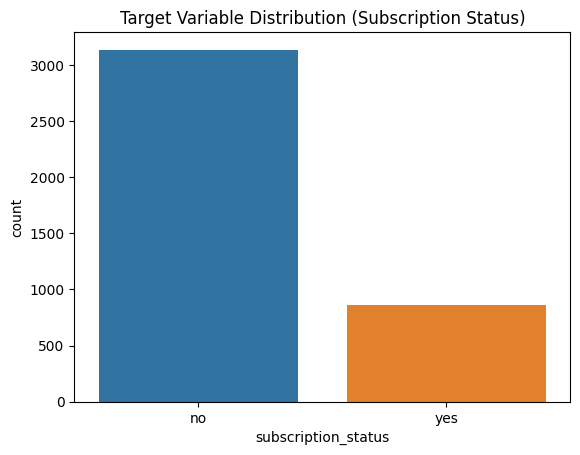

In [ ]:
# Distribution of the target variable
subscription_counts = data['subscription_status'].value_counts()
print(f"Target Variable Distribution:\n{subscription_counts}")

logging.info("Plotting target variable distribution")
sns.countplot(x=data['subscription_status'], hue=data['subscription_status'], palette=['#1f77b4', '#ff7f0e'], legend=False)
plt.title("Target Variable Distribution (Subscription Status)")
plt.show()


Mapping of target variable:
{'no': 0, 'yes': 1}
0 maps to 'NO' and 1 maps to 'YES'


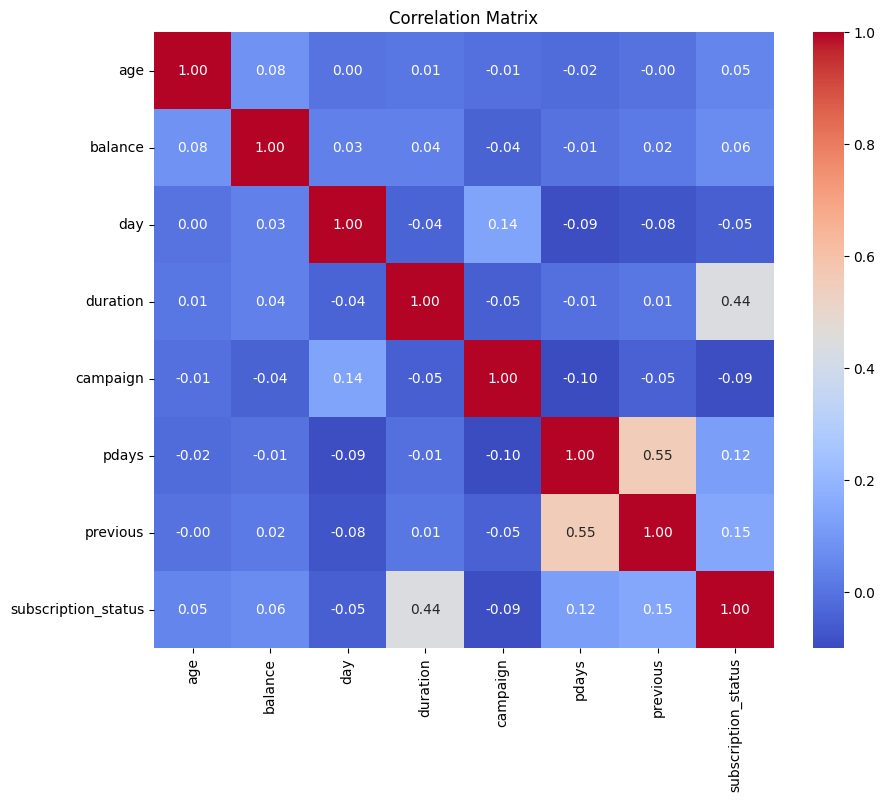

In [ ]:
# Encoding the target variable
label_encoder = LabelEncoder()
data['subscription_status'] = label_encoder.fit_transform(data['subscription_status'])

# Verify the mapping
mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Mapping of target variable:")
print(mapping)

# Verify if 0 maps to "NO" and 1 maps to "YES"
if mapping.get('no') == 0 and mapping.get('yes') == 1:
    print("0 maps to 'NO' and 1 maps to 'YES'")
else:
    print("Mapping does not match")

# Correlation Matrix
numeric_data = data.select_dtypes(include=['number'])
correlation_matrix = numeric_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [ ]:
# Performing Chi-Square Test
categorical_data = data.select_dtypes(include=['object']).columns

for feature in categorical_data:

    contingency_table = pd.crosstab(data[feature], data['subscription_status'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    print(f"Chi-Square Test for {feature}:")
    print(f"Chi-Square Statistic: {chi2:.4f}")
    print(f"P-value: {p:.4f}")
    print(f"Degrees of Freedom: {dof}")
    print("Expected Frequencies:")
    print(expected)
    print("\n")

    if p < 0.05:
        print(f"There is a significant association between {feature} and subscription_status (p < 0.05).")
    else:
        print(f"There is no significant association between {feature} and subscription_status (p >= 0.05).")
    print("-" * 50)

Chi-Square Test for job:
Chi-Square Statistic: 123.5425
P-value: 0.0000
Degrees of Freedom: 11
Expected Frequencies:
[[371.18675 101.81325]
 [626.2305  171.7695 ]
 [ 97.309    26.691  ]
 [ 96.52425  26.47575]
 [629.3695  172.6305 ]
 [185.201    50.799  ]
 [112.21925  30.78075]
 [297.42025  81.57975]
 [ 64.3495   17.6505 ]
 [539.908   148.092  ]
 [ 95.7395   26.2605 ]
 [ 23.5425    6.4575 ]]


There is a significant association between job and subscription_status (p < 0.05).
--------------------------------------------------
Chi-Square Test for marital:
Chi-Square Statistic: 20.8611
P-value: 0.0000
Degrees of Freedom: 2
Expected Frequencies:
[[ 368.04775  100.95225]
 [1886.539    517.461  ]
 [ 884.41325  242.58675]]


There is a significant association between marital and subscription_status (p < 0.05).
--------------------------------------------------
Chi-Square Test for education:
Chi-Square Statistic: 29.0753
P-value: 0.0000
Degrees of Freedom: 3
Expected Frequencies:
[[ 467.711   1

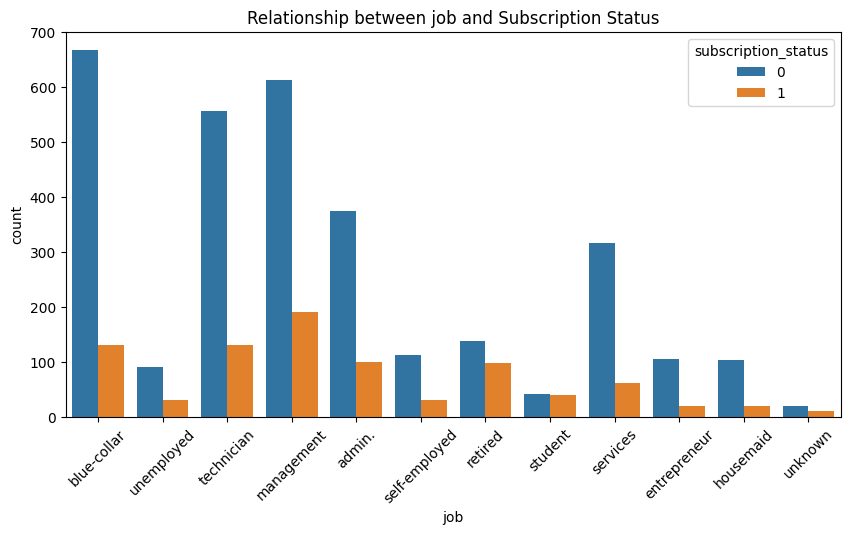

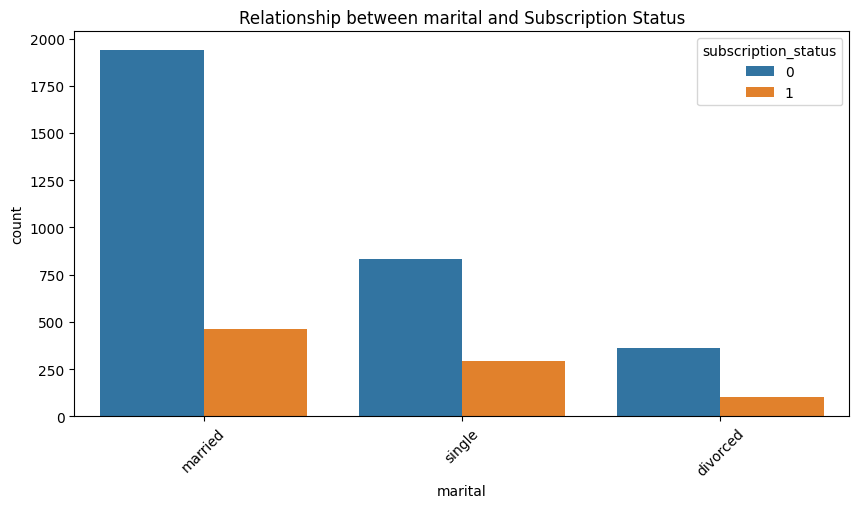

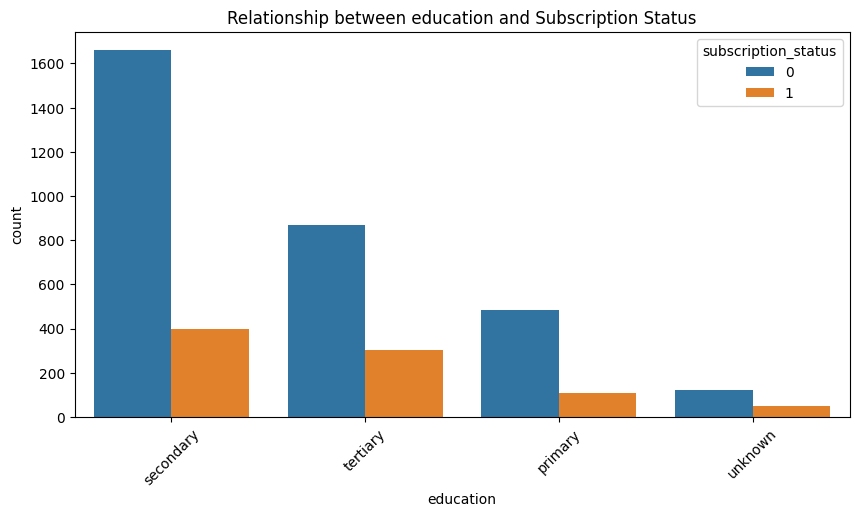

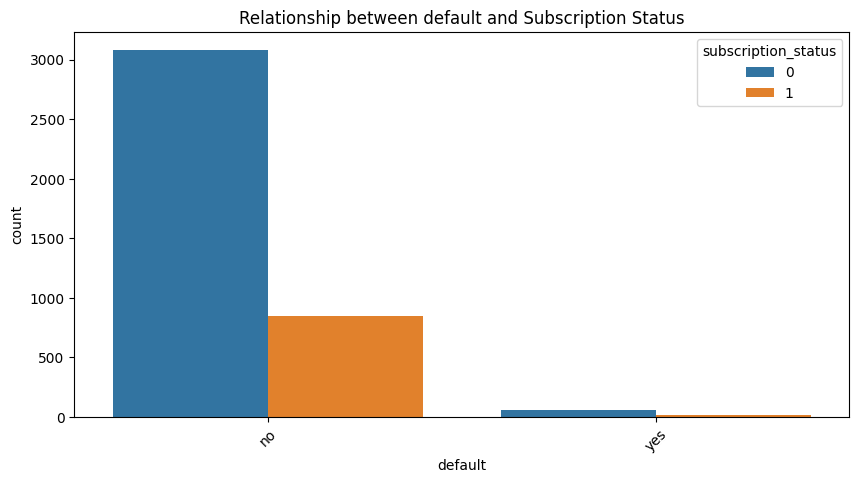

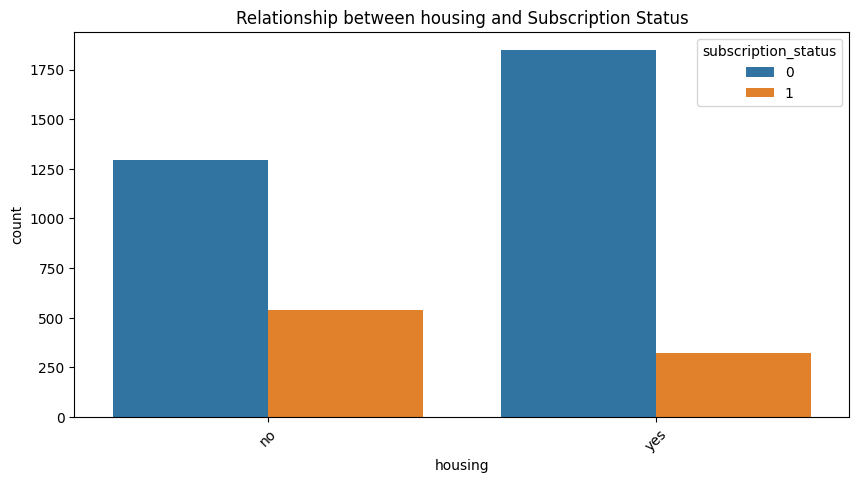

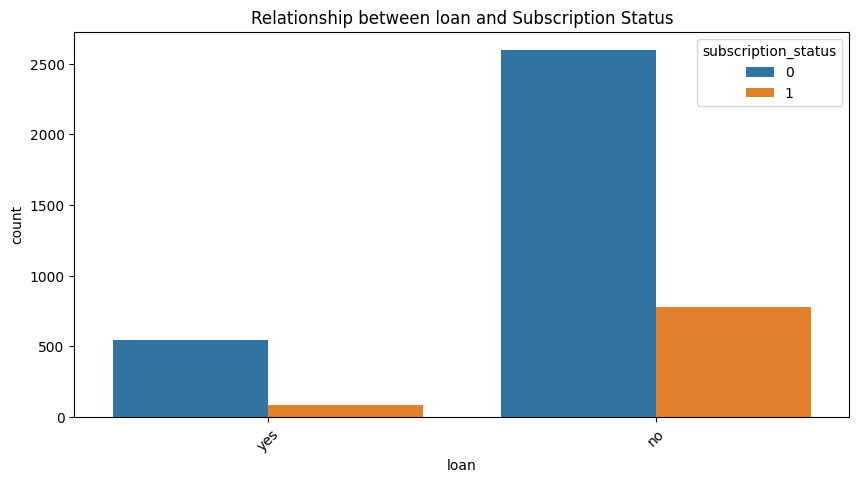

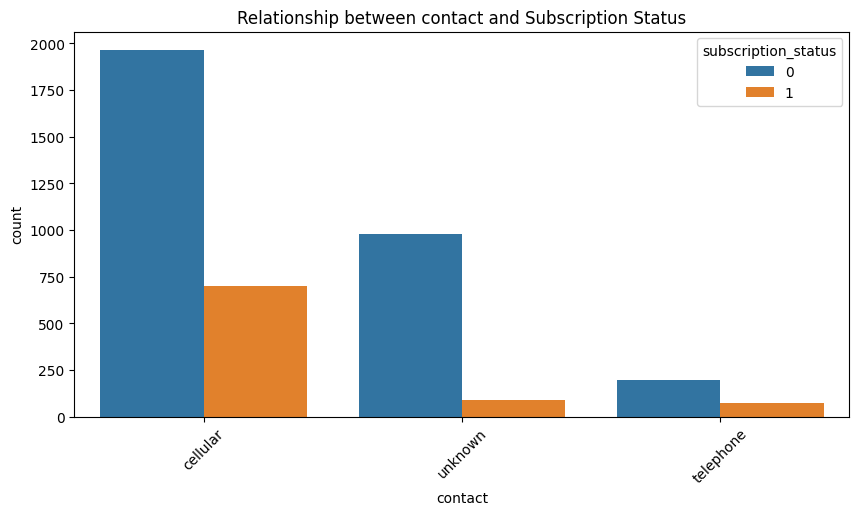

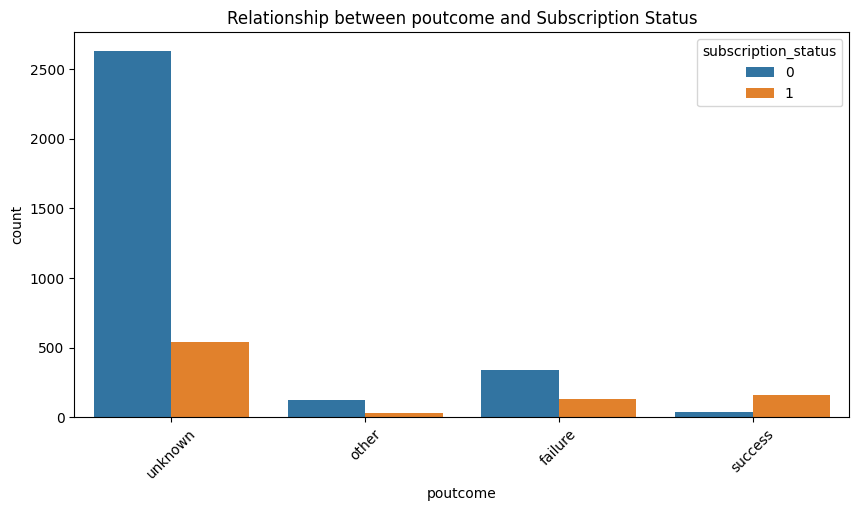

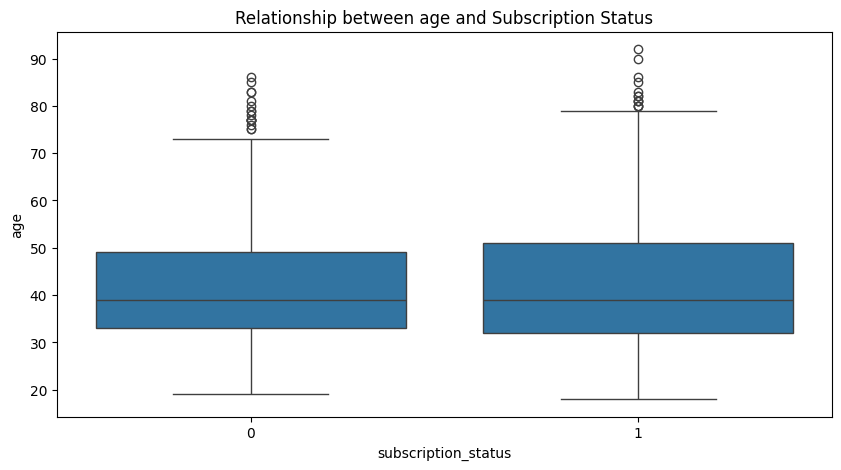

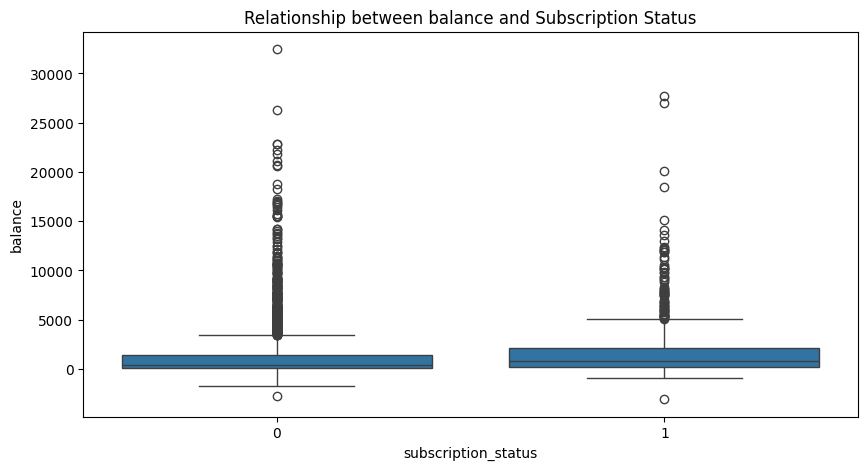

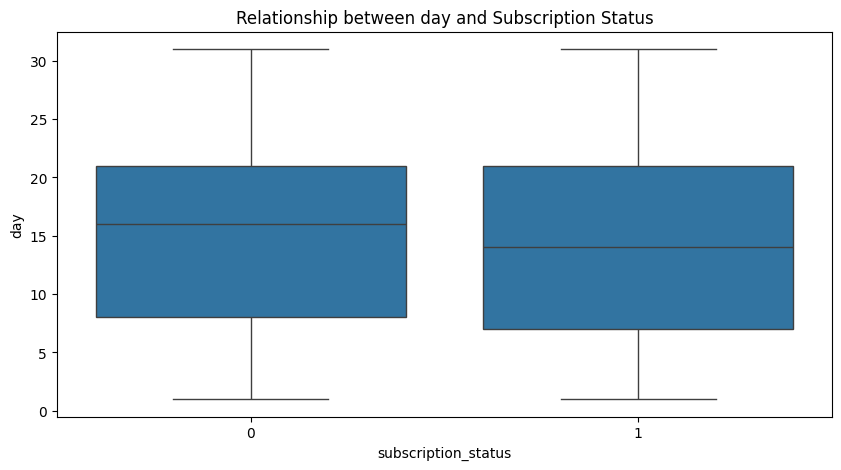

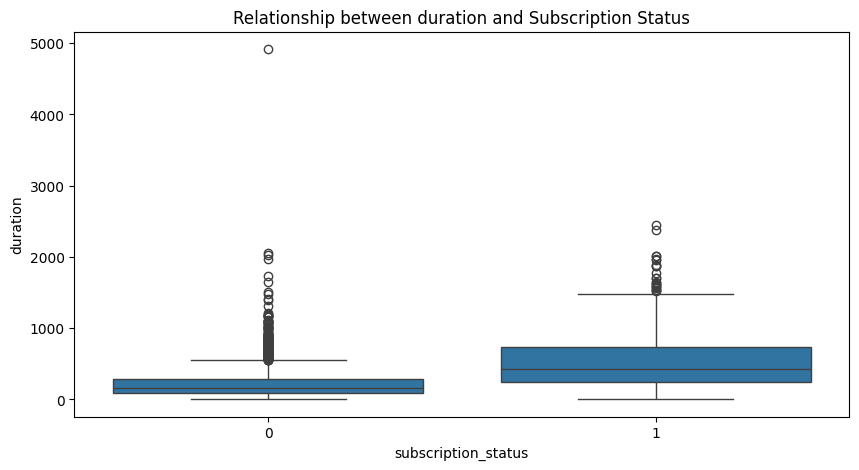

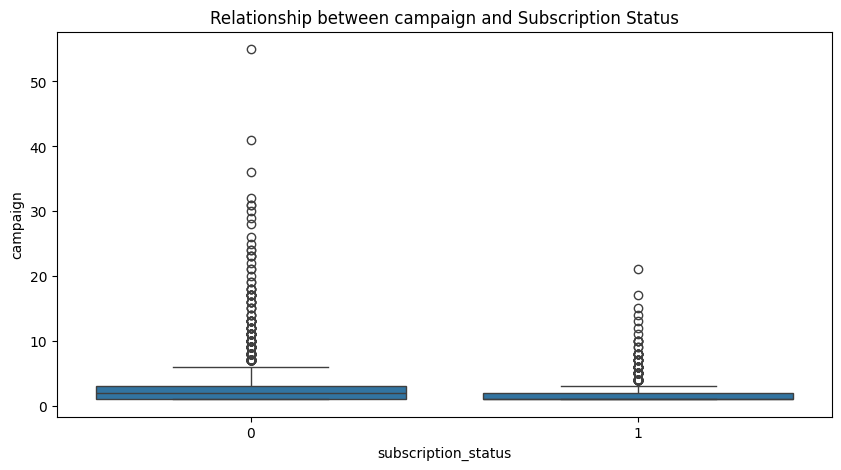

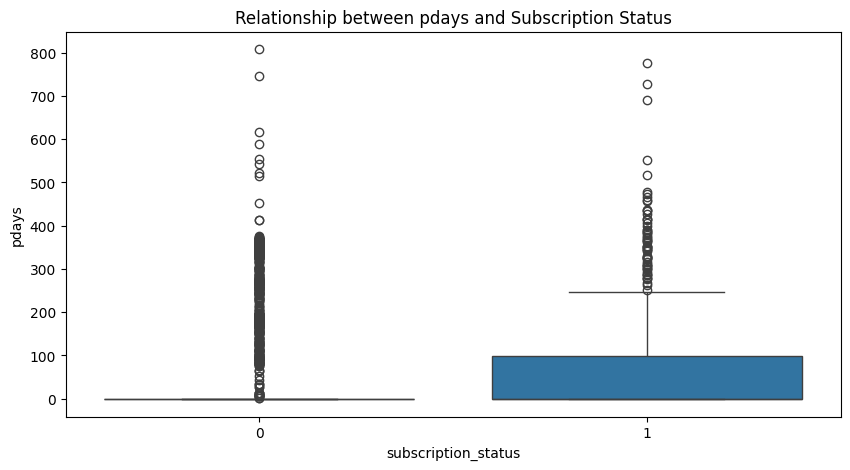

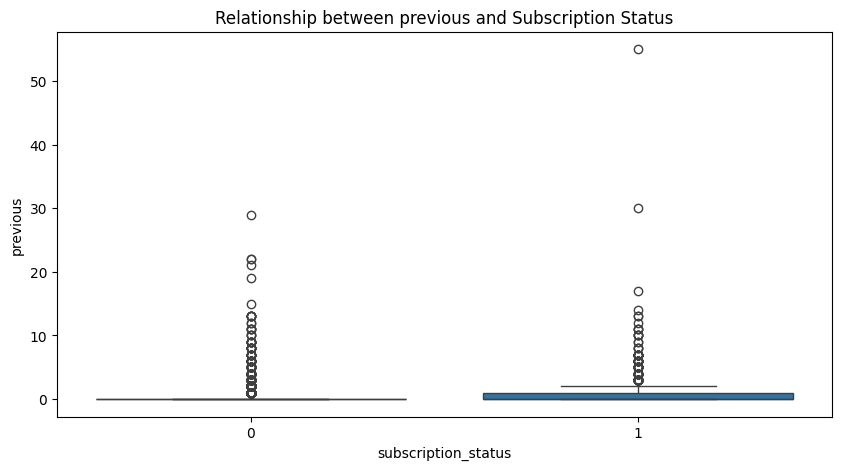

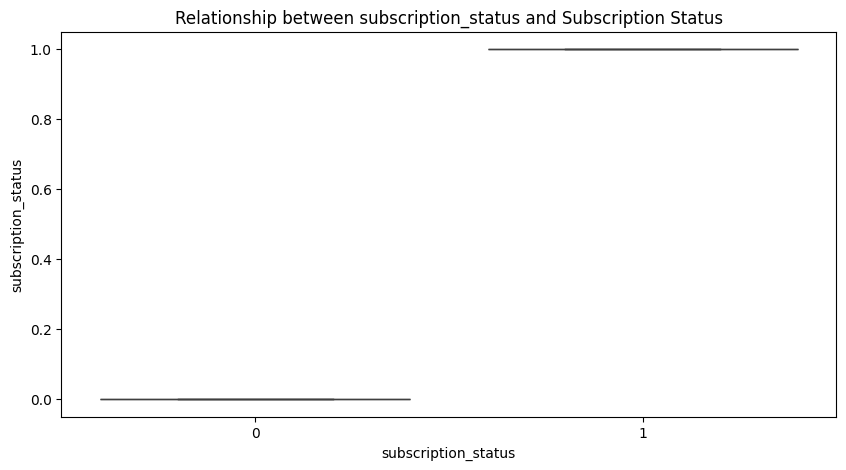

In [ ]:
# Bar chart for categorical features
for col in data.select_dtypes(include=['object']).columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=data, x=col, hue='subscription_status')
    plt.title(f"Relationship between {col} and Subscription Status")
    plt.xticks(rotation=45)
    plt.show()

# Boxplot for numerical features
for col in data.select_dtypes(include=['number']).columns:
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=data, x='subscription_status', y=col)
    plt.title(f"Relationship between {col} and Subscription Status")
    plt.show()


In [ ]:
# Create interaction terms
data['housing_loan_interaction'] = data['housing'] + "_" + data['loan']
data['marital_housing_interaction'] = data['marital'] + "_" + data['housing']
data['education_job_interaction'] = data['education'] + "_" + data['job']
data['contact_poutcome_interaction'] = data['contact'] + "_" + data['poutcome']
data['marital_loan_interaction'] = data['marital'] + "_" + data['loan']
data['job_housing_interaction'] = data['job'] + "_" + data['housing']

print(data[['housing_loan_interaction', 'marital_housing_interaction', 'education_job_interaction', 'contact_poutcome_interaction',
          'marital_loan_interaction', 'job_housing_interaction']].head())

  housing_loan_interaction marital_housing_interaction  \
0                   no_yes                  married_no   
1                    no_no                  married_no   
2                    no_no                  married_no   
3                   yes_no                  single_yes   
4                   yes_no                 married_yes   

  education_job_interaction contact_poutcome_interaction  \
0     secondary_blue-collar             cellular_unknown   
1      secondary_unemployed             cellular_unknown   
2      secondary_technician             cellular_unknown   
3       tertiary_management               cellular_other   
4       tertiary_unemployed              unknown_unknown   

  marital_loan_interaction job_housing_interaction  
0              married_yes          blue-collar_no  
1               married_no           unemployed_no  
2               married_no           technician_no  
3                single_no          management_yes  
4               married_n

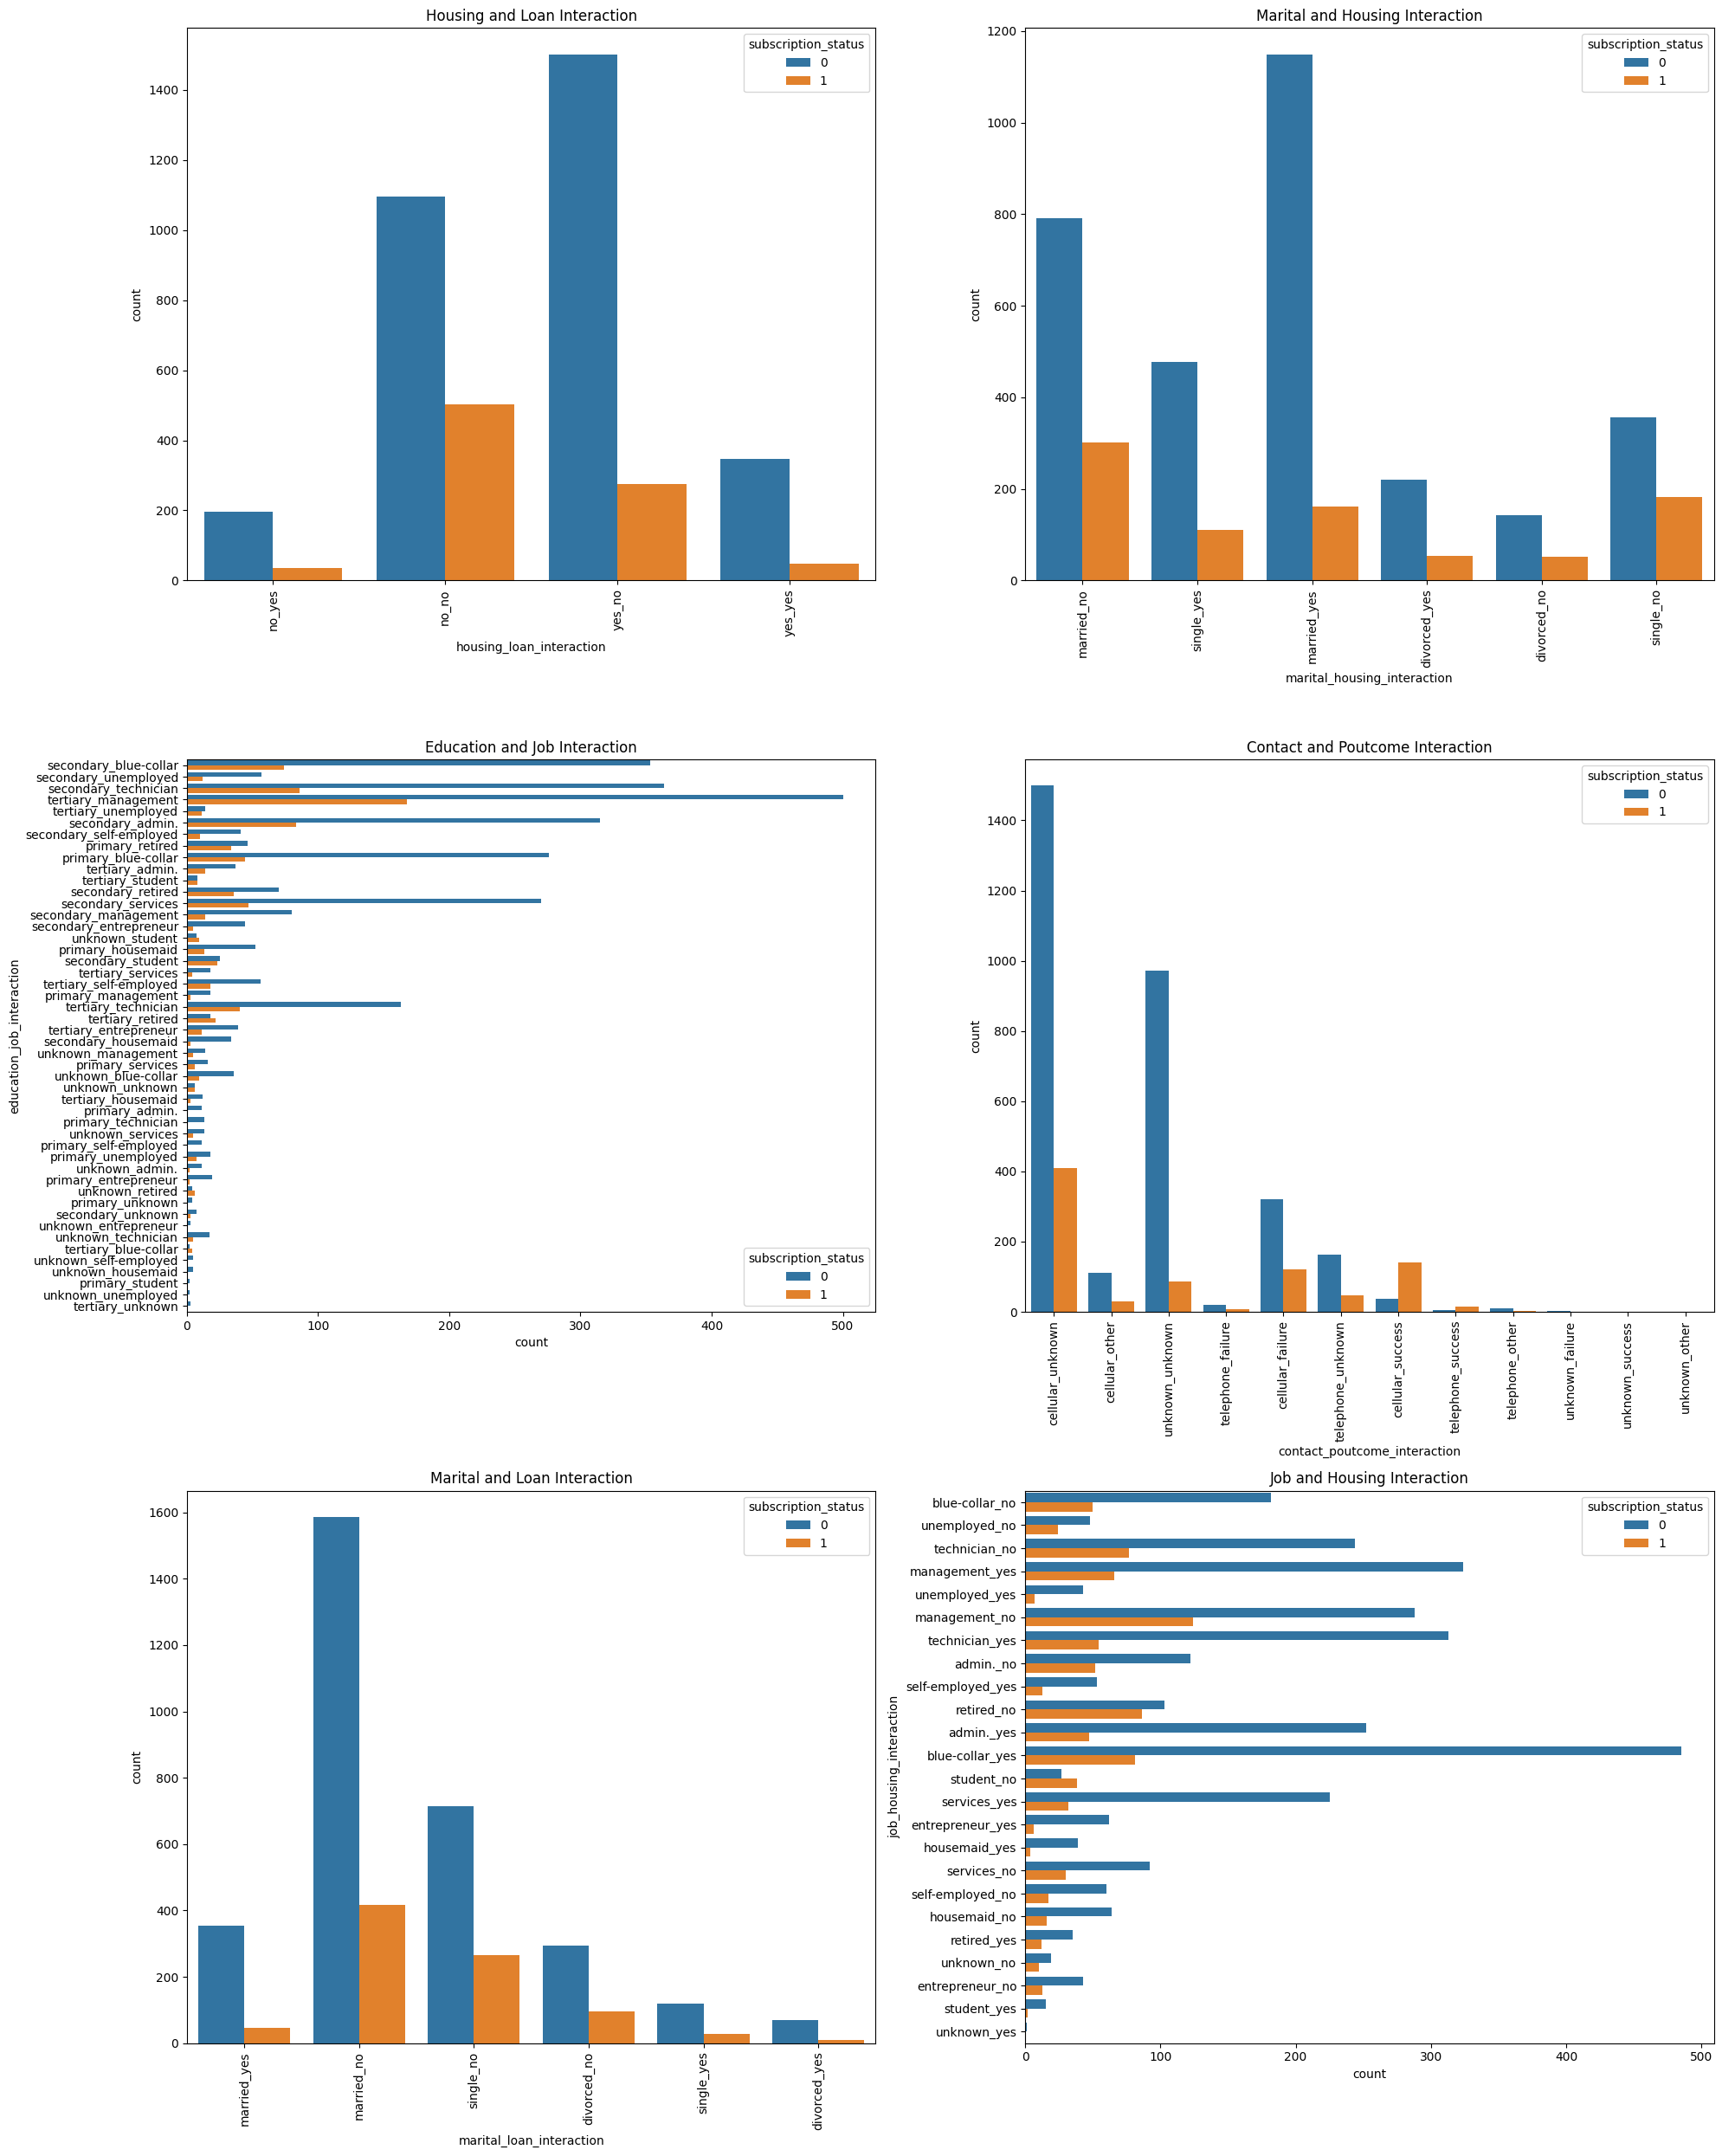

In [ ]:
# Plotting the interaction terms
plt.figure(figsize=(20, 25))

# Housing and Loan Interaction
plt.subplot(3, 2, 1)
sns.countplot(data=data, x='housing_loan_interaction', hue='subscription_status')
plt.title("Housing and Loan Interaction")
plt.xticks(rotation=90)

# Marital and Housing Interaction
plt.subplot(3, 2, 2)
sns.countplot(data=data, x='marital_housing_interaction', hue='subscription_status')
plt.title("Marital and Housing Interaction")
plt.xticks(rotation=90)

# Education and Job Interaction
plt.subplot(3, 2, 3)
sns.countplot(data=data, y='education_job_interaction', hue='subscription_status')  # Use y instead of x
plt.title("Education and Job Interaction")
plt.yticks(rotation=0)

# Contact and Poutcome Interaction
plt.subplot(3, 2, 4)
sns.countplot(data=data, x='contact_poutcome_interaction', hue='subscription_status')
plt.title("Contact and Poutcome Interaction")
plt.xticks(rotation=90)

# Marital and Loan Interaction
plt.subplot(3, 2, 5)
sns.countplot(data=data, x='marital_loan_interaction', hue='subscription_status')
plt.title("Marital and Loan Interaction")
plt.xticks(rotation=90)

# Job and Housing Interaction
plt.subplot(3, 2, 6)
sns.countplot(data=data, y='job_housing_interaction', hue='subscription_status')  # Use y instead of x
plt.title("Job and Housing Interaction")
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

After analysing, choosing these 3 Interaction Terms:-

*   Contact and Poutcome Interaction
*   Housing and Loan Interaction
*   Marital and Housing Interaction

Features considered - job, education, previous, pdays, balance, age

**Section B: Exploration**

Feature Importances:
                                           Feature  Importance
0                                         duration    0.642566
28   contact_poutcome_interaction_cellular_success    0.229756
37    contact_poutcome_interaction_unknown_unknown    0.073207
4                                              age    0.054472
21         marital_housing_interaction_married_yes    0.000000
22           marital_housing_interaction_single_no    0.000000
23          marital_housing_interaction_single_yes    0.000000
24                 housing_loan_interaction_no_yes    0.000000
25                 housing_loan_interaction_yes_no    0.000000
26                housing_loan_interaction_yes_yes    0.000000
27     contact_poutcome_interaction_cellular_other    0.000000
2                                            pdays    0.000000
3                                          balance    0.000000
30  contact_poutcome_interaction_telephone_failure    0.000000
31    contact_poutcome_interaction

<ipython-input-14-3201b12eee46>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


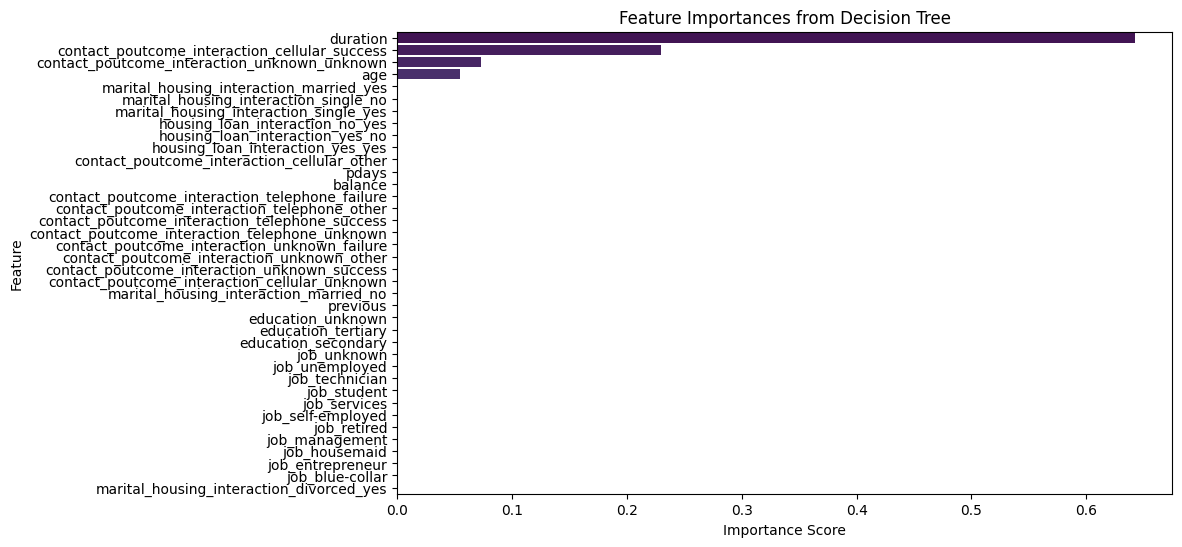

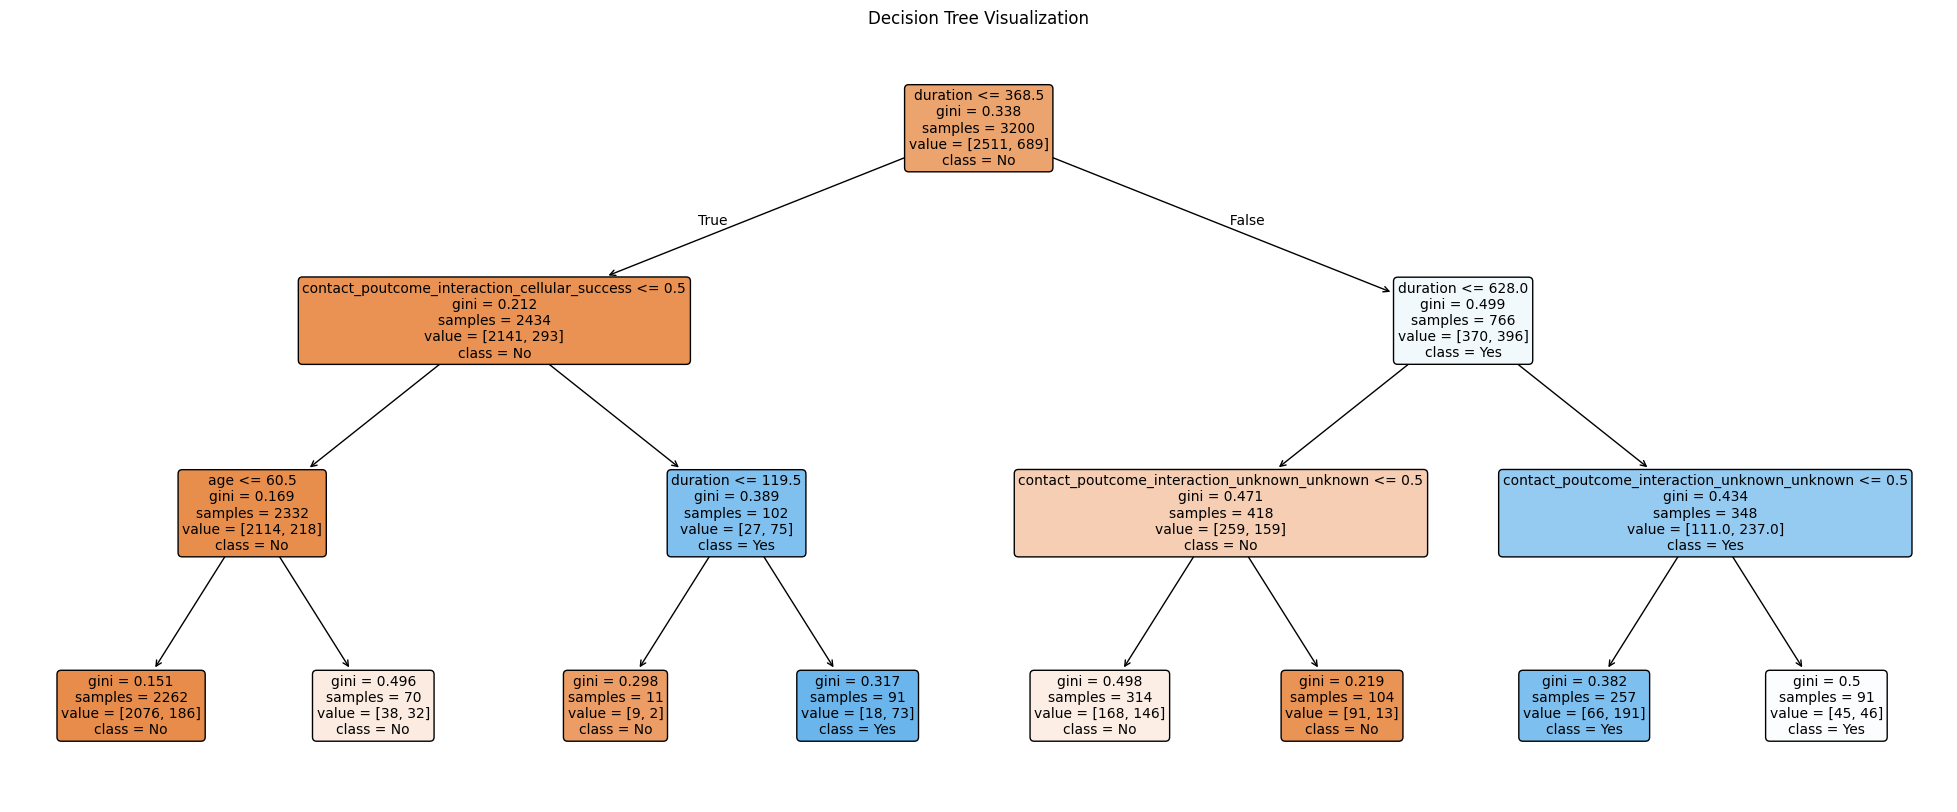

In [ ]:
# For decision tree visualization, included 'duration'
tree_features = [
    'job', 'education', 'marital_housing_interaction', 'housing_loan_interaction',
    'contact_poutcome_interaction', 'duration', 'previous', 'pdays', 'balance', 'age'
]

X_tree = data[tree_features]
y_tree = data['subscription_status']  # already encoded

# Encode categorical features for decision tree visualization
categorical_features_tree = X_tree.select_dtypes(include=['object']).columns
encoder_tree = OneHotEncoder(drop='first', sparse_output=False)
encoded_categorical_tree = encoder_tree.fit_transform(X_tree[categorical_features_tree])
encoded_df_tree = pd.DataFrame(encoded_categorical_tree, columns=encoder_tree.get_feature_names_out(categorical_features_tree))

X_tree = pd.concat([X_tree.drop(columns=categorical_features_tree).reset_index(drop=True), encoded_df_tree], axis=1)

# Split data for Decision Tree
X_train, X_test, y_train, y_test = train_test_split(X_tree, y_tree, test_size=0.2, random_state=42, stratify=y_tree)

# Train a decision tree model
decision_tree = DecisionTreeClassifier(max_depth=3, random_state=42)
decision_tree.fit(X_train, y_train)

# Get feature importances
feature_importances = decision_tree.feature_importances_
feature_names = X_tree.columns

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the most important features
print("Feature Importances:")
print(importance_df)

# Visualize feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title("Feature Importances from Decision Tree")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

# Visualize the decision tree
plt.figure(figsize=(25, 10))
plot_tree(
    decision_tree,
    feature_names=feature_names,
    class_names=['No', 'Yes'],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Visualization")
plt.show()

In [ ]:
# Excluded duration
selected_features = ['job', 'education', 'marital_housing_interaction', 'housing_loan_interaction',
                     'contact_poutcome_interaction', 'previous', 'pdays', 'balance', 'age']

X = data[selected_features]
y = data['subscription_status'] # already encoded one

print(f"Features X shape: {X.shape}")
print(f"Target y shape: {y.shape}")
print(f"X data types:\n{X.dtypes}")

Features X shape: (4000, 9)
Target y shape: (4000,)
X data types:
job                              object
education                        object
marital_housing_interaction      object
housing_loan_interaction         object
contact_poutcome_interaction     object
previous                        float64
pdays                           float64
balance                         float64
age                             float64
dtype: object


In [ ]:
categorical_features = X.select_dtypes(include=['object']).columns
numeric_features = X.select_dtypes(include=['number']).columns

print(f"Categorical Features:-\n {categorical_features}")
print(f"Numeric Features:-\n {numeric_features}")

Categorical Features:-
 Index(['job', 'education', 'marital_housing_interaction',
       'housing_loan_interaction', 'contact_poutcome_interaction'],
      dtype='object')
Numeric Features:-
 Index(['previous', 'pdays', 'balance', 'age'], dtype='object')


In [ ]:
# Encoding categorical variables and scaling numerical variables before oversampling

encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_categorical = encoder.fit_transform(X[categorical_features])
encoded_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(categorical_features))

X = pd.concat([X.drop(columns=categorical_features).reset_index(drop=True), encoded_df], axis=1)
assert not set(categorical_features).intersection(X.columns), "Redundant columns found after encoding!"

# Ensure all column names in X are strings
X.columns = X.columns.astype(str)


In [ ]:
# Splitting the samples for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3200, 37) (800, 37) (3200,) (800,)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Original training class distribution:
subscription_status
0    0.784687
1    0.215312
Name: proportion, dtype: float64

Resampled training class distribution:
subscription_status
1    0.5
0    0.5
Name: proportion, dtype: float64


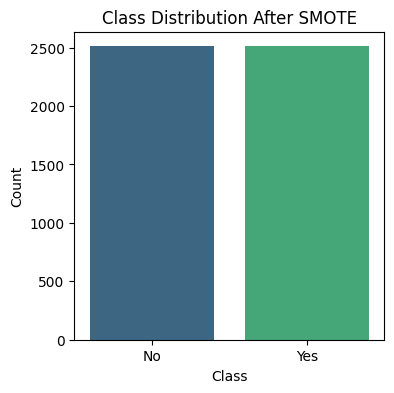

Shapes after SMOTE resampling:
(5022, 37) (800, 37) (5022,) (800,)


In [ ]:
# Oversampling with SMOTE to address the imbalance in the dataset - applying only on the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Checking out the original and resampled class distributions
print("Original training class distribution:")
print(pd.Series(y_train).value_counts(normalize=True))
print("\nResampled training class distribution:")
print(pd.Series(y_train_resampled).value_counts(normalize=True))

# Class distribution after SMOTE
plt.figure(figsize=(4, 4))
sns.countplot(x=y_train_resampled, hue=y_train_resampled, palette='viridis', legend=False)
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.show()

print("Shapes after SMOTE resampling:")
print(X_train_resampled.shape, X_test.shape, y_train_resampled.shape, y_test.shape)


In [ ]:
# Updating numeric_features dynamically after OneHotEncoding
encoded_columns = encoder.get_feature_names_out(categorical_features)
all_columns = X.columns
updated_numeric_features = [col for col in numeric_features if col in all_columns and col not in encoded_columns]

print(f"Numeric features: {updated_numeric_features}")

Numeric features: ['previous', 'pdays', 'balance', 'age']


**Section C: Model Evaluation**

In [ ]:
#Setting up preprocessors for Linear and Tree-Based Models

# Linear Models
preprocessor_linear = ColumnTransformer(
     transformers=[('scale', StandardScaler(), updated_numeric_features)],
     remainder='passthrough'  # Keep all other columns as-is
)

# Tree-Based Models
preprocessor_tree = ColumnTransformer(
    transformers=[],
    remainder='passthrough'  # Tree models don't need scaling
)


In [ ]:
# Configuring pipelines to organize preprocessing

pipe_lr = Pipeline(steps=[
    ('preprocessor', preprocessor_linear),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

pipe_nb = Pipeline(steps=[
    ('preprocessor', preprocessor_linear),
    ('classifier', GaussianNB())
])

pipe_tree = Pipeline(steps=[
    ('preprocessor', preprocessor_tree),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

pipe_rf = Pipeline(steps=[
    ('preprocessor', preprocessor_tree),
    ('classifier', RandomForestClassifier(random_state=42))
])

pipe_knn = Pipeline(steps=[
    ('preprocessor', preprocessor_linear),
    ('classifier', KNeighborsClassifier(n_neighbors=5))
])

In [ ]:
# Hyperparameter tuning using RandomizedSearchCV
param_grid_lr = {'classifier__C': [0.01, 0.1, 1, 10, 100], 'classifier__penalty': ['l1', 'l2'], 'classifier__solver': ['liblinear', 'saga'],
    'classifier__max_iter': [100, 200, 500, 1000, 2000, 5000],
    'classifier__tol': [1e-4, 1e-3, 1e-2]}
param_grid_nb = {'classifier__var_smoothing': np.logspace(-9, 0, 10)}
param_grid_tree = {
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__criterion': ['gini', 'entropy'] #Splitting Criteria
}
param_grid_rf = {
    'classifier__n_estimators': [10, 50, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__criterion': ['gini', 'entropy']
}
param_grid_knn = {'classifier__n_neighbors': [3, 5, 7, 10, 15], 'classifier__weights': ['uniform', 'distance'], 'classifier__metric': ['euclidean', 'manhattan', 'minkowski']}

def tune_model(pipeline, param_grid, X_train, y_train):
    scoring = {
        'precision': make_scorer(precision_score, average='binary'),
        'recall': make_scorer(recall_score, average='binary'),
        'f1': make_scorer(f1_score, average='binary'),
        'roc_auc': make_scorer(roc_auc_score)
    }

    # Using RandomizedSearchCV for faster tuning
    random_search = RandomizedSearchCV(pipeline, param_grid, n_iter=10, cv=5, scoring=scoring, refit='precision', random_state=42, n_jobs=-1)
    random_search.fit(X_train, y_train)

    print(f"Best parameters for {pipeline['classifier'].__class__.__name__}: {random_search.best_params_}")
    print(f"Best Precision score: {random_search.best_score_:.4f}")
    print(f"Best Recall score: {random_search.cv_results_['mean_test_recall'][random_search.best_index_]:.4f}")
    print(f"Best F1 score: {random_search.cv_results_['mean_test_f1'][random_search.best_index_]:.4f}")
    print(f"Best ROC AUC score: {random_search.cv_results_['mean_test_roc_auc'][random_search.best_index_]:.4f}")

    return random_search.best_estimator_

pipeline_lr = tune_model(pipe_lr, param_grid_lr, X_train_resampled, y_train_resampled)
pipeline_nb = tune_model(pipe_nb, param_grid_nb, X_train_resampled, y_train_resampled)
pipeline_tree = tune_model(pipe_tree, param_grid_tree, X_train_resampled, y_train_resampled)
pipeline_rf = tune_model(pipe_rf, param_grid_rf, X_train_resampled, y_train_resampled)
pipeline_knn = tune_model(pipe_knn, param_grid_knn, X_train_resampled, y_train_resampled)


Best parameters for LogisticRegression: {'classifier__tol': 0.0001, 'classifier__solver': 'saga', 'classifier__penalty': 'l2', 'classifier__max_iter': 5000, 'classifier__C': 10}
Best Precision score: 0.6731
Best Recall score: 0.6862
Best F1 score: 0.6794
Best ROC AUC score: 0.6760
Best parameters for GaussianNB: {'classifier__var_smoothing': 0.0001}
Best Precision score: 0.7526
Best Recall score: 0.4596
Best F1 score: 0.5690
Best ROC AUC score: 0.6529
Best parameters for DecisionTreeClassifier: {'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 10, 'classifier__criterion': 'gini'}
Best Precision score: 0.8367
Best Recall score: 0.7608
Best F1 score: 0.7742
Best ROC AUC score: 0.8079
Best parameters for RandomForestClassifier: {'classifier__n_estimators': 100, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 10, 'classifier__criterion': 'gini'}
Best Precision score: 0.9310
Best Recall score: 0.

In [ ]:
# Precision-Recall Curve Plotting
def plot_precision_recall_curve(pipeline_model, X_test, y_test, model_name):
    y_probs = pipeline_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
    precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'AUC-PR: {pr_auc:.4f}', color='blue')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
# Setting up a function to train and evaluate all models

metrics_dict = {}

def train_evaluate_model(pipeline, X_train, X_test, y_train, y_test, model_name, cmap='Blues'):
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    y_probs = pipeline.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

    # Calculate metrics
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='binary')
    recall = recall_score(y_test, predictions, average='binary')
    f1 = f1_score(y_test, predictions, average='binary')
    roc_auc = roc_auc_score(y_test, y_probs)

    metrics_dict[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "ROC AUC": roc_auc
    }

    print(f"{model_name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, ROC AUC: {roc_auc:.4f}")
    print(f"{model_name}:\n", classification_report(y_test, predictions))

    cm = confusion_matrix(y_test, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap)
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Plot Precision-Recall Curve
    plot_precision_recall_curve(pipeline, X_test, y_test, model_name)

    return predictions

Logistic Regression - Accuracy: 0.6338, Precision: 0.3183, Recall: 0.6163, F1 Score: 0.4198, ROC AUC: 0.7059
Logistic Regression:
               precision    recall  f1-score   support

           0       0.86      0.64      0.73       628
           1       0.32      0.62      0.42       172

    accuracy                           0.63       800
   macro avg       0.59      0.63      0.58       800
weighted avg       0.74      0.63      0.67       800



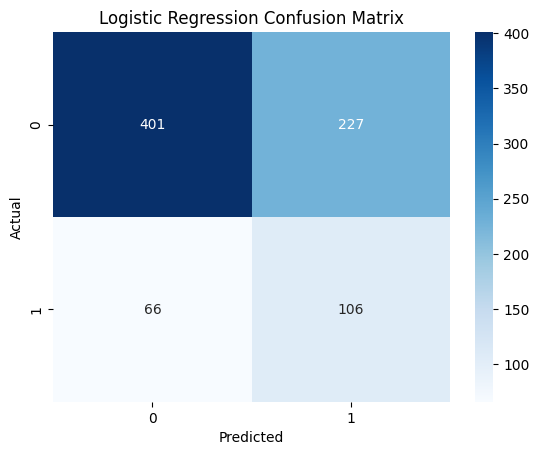

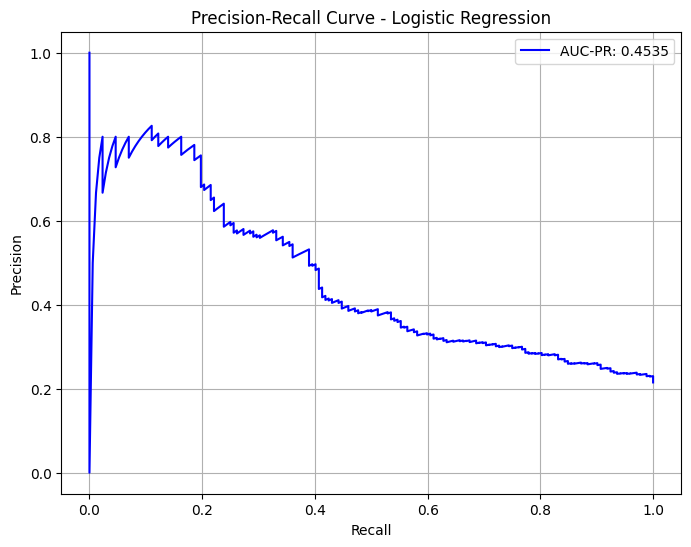

In [ ]:
# Logistic Regression
logistic_predictions = train_evaluate_model(
    pipeline_lr, X_train_resampled, X_test, y_train_resampled, y_test, "Logistic Regression", cmap='Blues'
)

Naive Bayes - Accuracy: 0.7512, Precision: 0.4270, Recall: 0.4593, F1 Score: 0.4426, ROC AUC: 0.6748
Naive Bayes:
               precision    recall  f1-score   support

           0       0.85      0.83      0.84       628
           1       0.43      0.46      0.44       172

    accuracy                           0.75       800
   macro avg       0.64      0.65      0.64       800
weighted avg       0.76      0.75      0.75       800



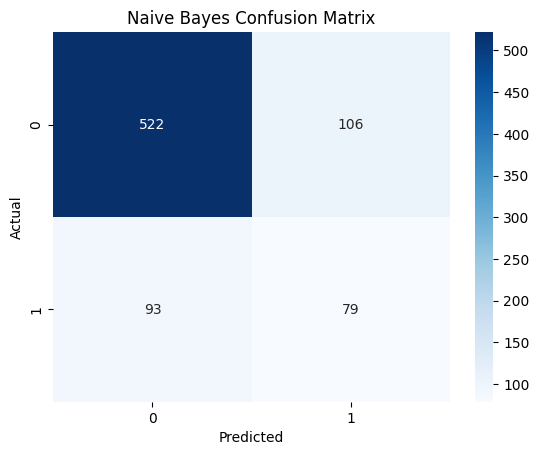

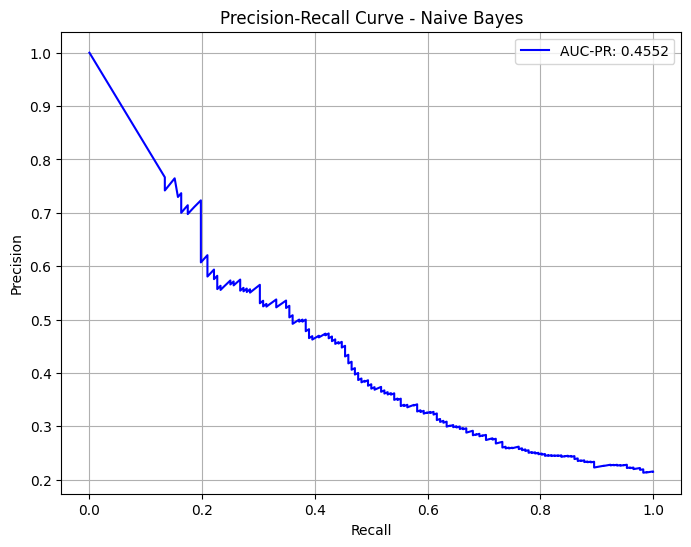

In [ ]:
# Naive Bayes
nb_predictions = train_evaluate_model(
    pipeline_nb, X_train_resampled, X_test, y_train_resampled, y_test, "Naive Bayes", cmap='Blues'
)

Decision Tree - Accuracy: 0.7400, Precision: 0.4053, Recall: 0.4477, F1 Score: 0.4254, ROC AUC: 0.7071
Decision Tree:
               precision    recall  f1-score   support

           0       0.84      0.82      0.83       628
           1       0.41      0.45      0.43       172

    accuracy                           0.74       800
   macro avg       0.62      0.63      0.63       800
weighted avg       0.75      0.74      0.74       800



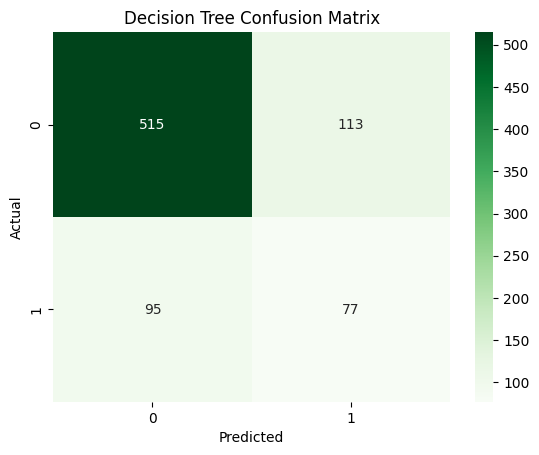

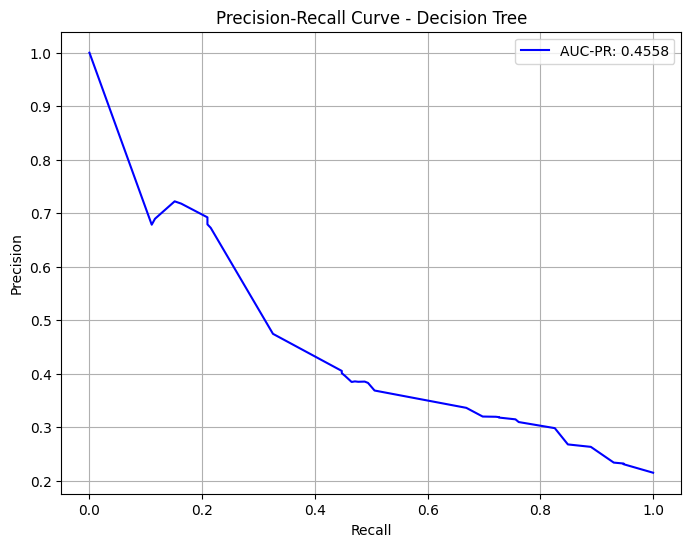

In [ ]:
# Decision Tree
decision_tree_predictions = train_evaluate_model(
    pipeline_tree, X_train_resampled, X_test, y_train_resampled, y_test, "Decision Tree", cmap='Greens'
)

Random Forest - Accuracy: 0.8137, Precision: 0.6211, Recall: 0.3430, F1 Score: 0.4419, ROC AUC: 0.7249
Random Forest:
               precision    recall  f1-score   support

           0       0.84      0.94      0.89       628
           1       0.62      0.34      0.44       172

    accuracy                           0.81       800
   macro avg       0.73      0.64      0.67       800
weighted avg       0.79      0.81      0.79       800



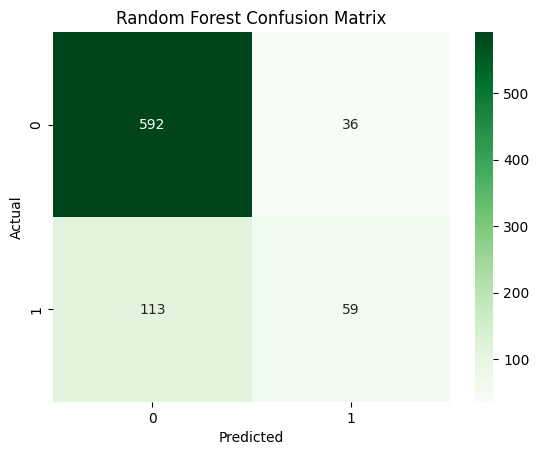

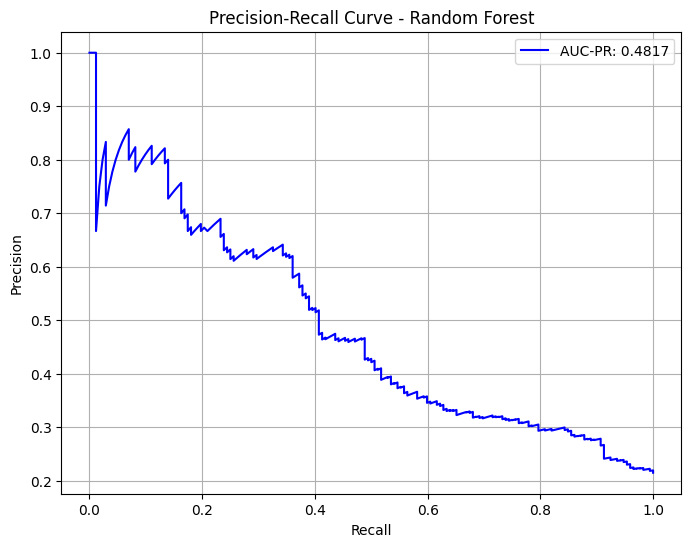

In [ ]:
# Random Forest
random_forest_predictions = train_evaluate_model(
    pipeline_rf, X_train_resampled, X_test, y_train_resampled, y_test, "Random Forest", cmap='Greens'
)

K-Nearest Neighbors - Accuracy: 0.7762, Precision: 0.4748, Recall: 0.3837, F1 Score: 0.4244, ROC AUC: 0.6694
K-Nearest Neighbors:
               precision    recall  f1-score   support

           0       0.84      0.88      0.86       628
           1       0.47      0.38      0.42       172

    accuracy                           0.78       800
   macro avg       0.66      0.63      0.64       800
weighted avg       0.76      0.78      0.77       800



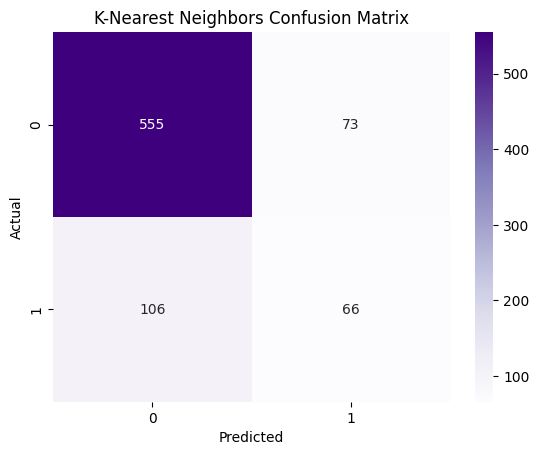

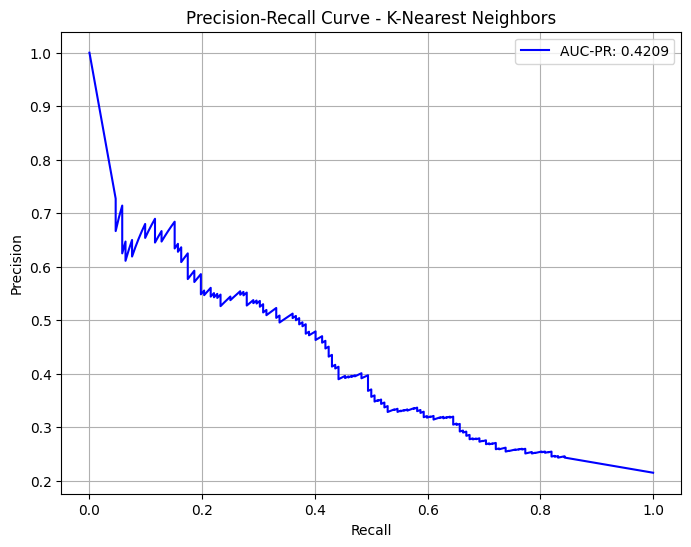

In [ ]:
# K-Nearest Neighbors
knn_predictions = train_evaluate_model(
    pipeline_knn, X_train_resampled, X_test, y_train_resampled, y_test, "K-Nearest Neighbors", cmap='Purples'
)

In [ ]:
# Checking if all the predictions has the correct shape
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of logistic_predictions: {logistic_predictions.shape}")
print(f"Shape of nb_predictions: {nb_predictions.shape}")
print(f"Shape of decision_tree_predictions: {decision_tree_predictions.shape}")
print(f"Shape of random_forest_predictions: {random_forest_predictions.shape}")
print(f"Shape of knn_predictions: {knn_predictions.shape}")

Shape of y_test: (800,)
Shape of logistic_predictions: (800,)
Shape of nb_predictions: (800,)
Shape of decision_tree_predictions: (800,)
Shape of random_forest_predictions: (800,)
Shape of knn_predictions: (800,)


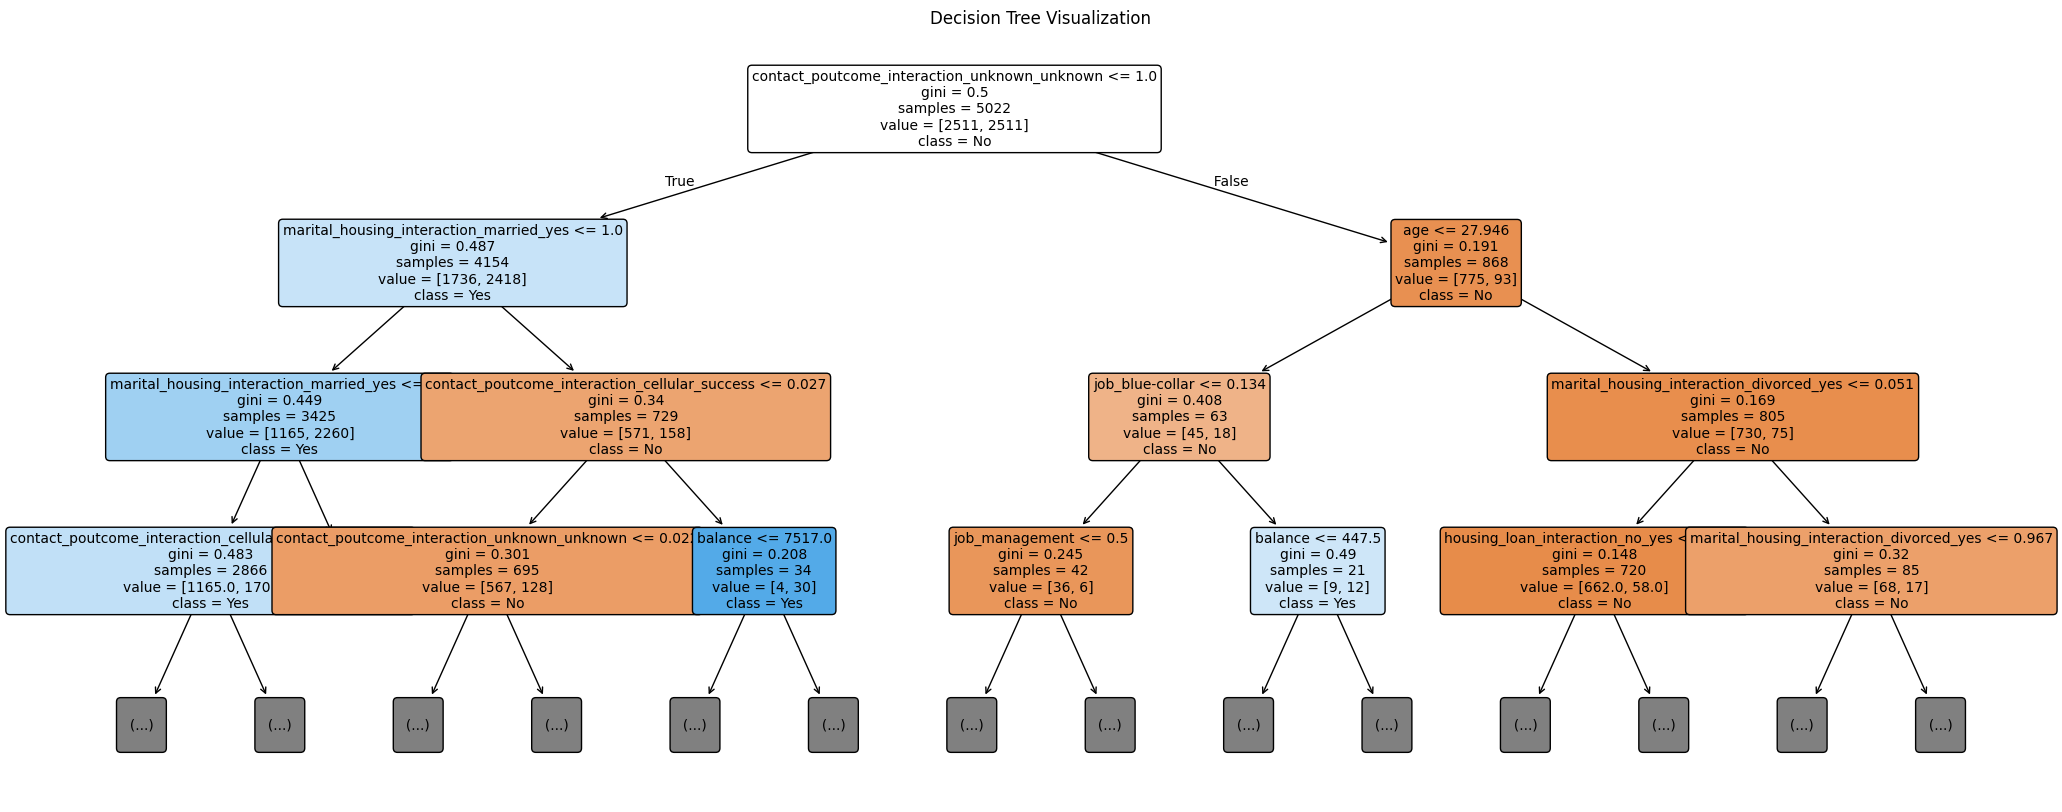

In [ ]:
# Extracting the decision tree model from the pipeline
decision_tree_model = pipeline_tree.named_steps['classifier']

plt.figure(figsize=(25, 10))
plot_tree(
    decision_tree_model,
    max_depth=3,
    feature_names=X.columns,
    class_names=['No', 'Yes'],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Visualization")
plt.show()

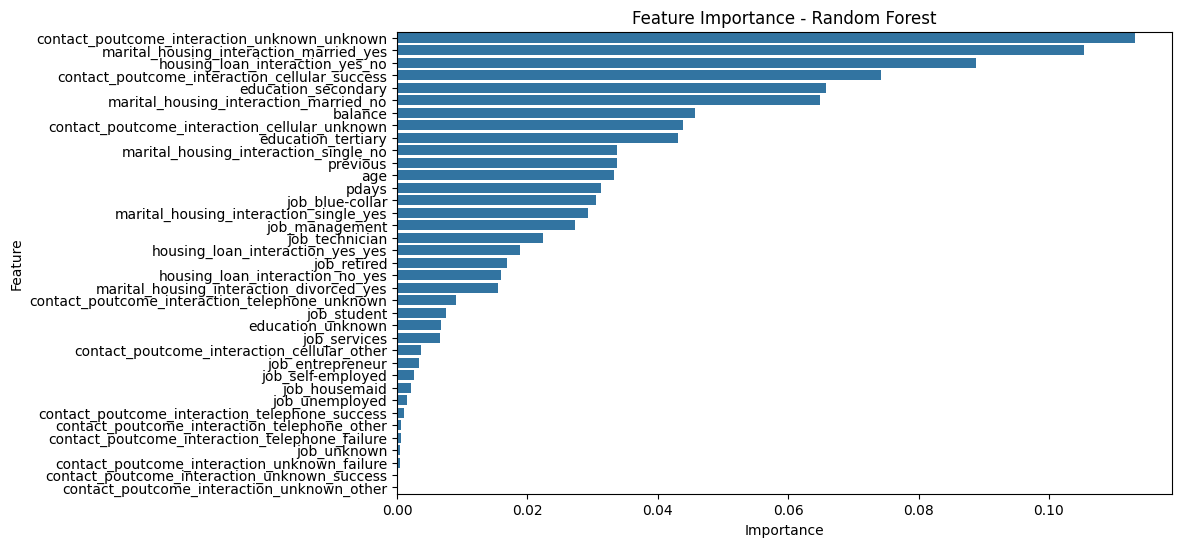

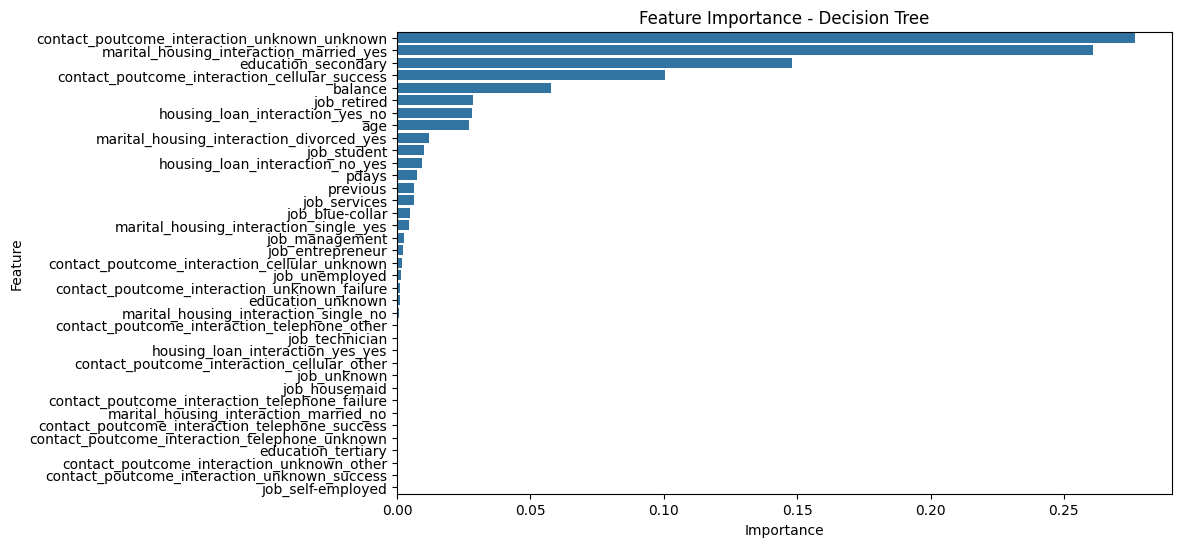

In [ ]:
# Feature Importance Analysis
def feature_importance_analysis(model, X_train, model_name):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_names = X_train.columns
        importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        importance_df = importance_df.sort_values(by='Importance', ascending=False)

        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=importance_df)
        plt.title(f"Feature Importance - {model_name}")
        plt.show()

# Random Forest Feature Importance
feature_importance_analysis(pipeline_rf.named_steps['classifier'], pd.DataFrame(X_train_resampled, columns=X.columns), "Random Forest")

# Decision Tree Feature Importance
feature_importance_analysis(pipeline_tree.named_steps['classifier'], pd.DataFrame(X_train_resampled, columns=X.columns), "Decision Tree")

Model Comparison Summary:
                     Accuracy  Precision    Recall  F1 Score   ROC AUC
Logistic Regression   0.63375   0.318318  0.616279  0.419802  0.705877
Naive Bayes           0.75125   0.427027  0.459302  0.442577  0.674803
Decision Tree         0.74000   0.405263  0.447674  0.425414  0.707067
Random Forest         0.81375   0.621053  0.343023  0.441948  0.724916
K-Nearest Neighbors   0.77625   0.474820  0.383721  0.424437  0.669433


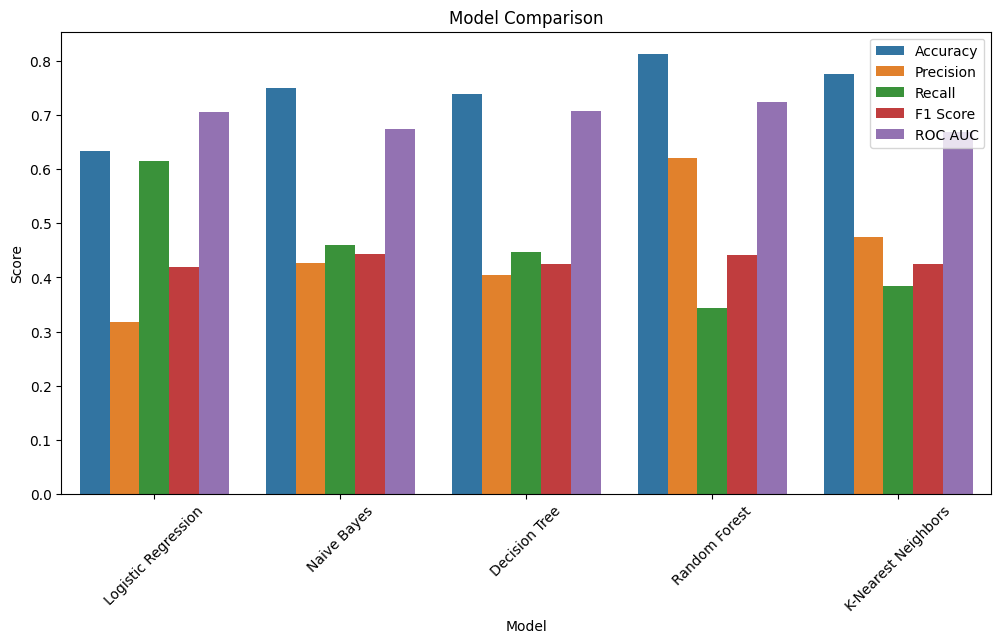

In [ ]:
# Comparing all the Model performances :-

# DataFrame from the metrics dictionary
results_df = pd.DataFrame.from_dict(metrics_dict, orient='index')

# Table
print("Model Comparison Summary:")
print(results_df)

# Melt the DataFrame for easier plotting
results_melted_df = results_df.reset_index().melt(id_vars="index", var_name="Metric", value_name="Score")

# Plotting the evaluation metrics
plt.figure(figsize=(12, 6))
sns.barplot(x="index", y="Score", hue="Metric", data=results_melted_df)
plt.title("Model Comparison")
plt.xlabel("Model")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.show()


**Section D: Final Assessment**

Choosing Random Forest as the Final Model

In [ ]:
# Random Forest as the final model
final_model = pipeline_rf

In [ ]:
# Cross-validation with multiple metrics
scoring = ['precision', 'recall', 'f1', 'roc_auc']
cv_results = cross_validate(final_model, X_train_resampled, y_train_resampled, cv=10, scoring=scoring)

for metric in scoring:
    print(f"Mean CV {metric}: {np.mean(cv_results[f'test_{metric}']):.4f}")

# Retrain on the entire training set to leverage all available data
final_model.fit(X_train_resampled, y_train_resampled)

Mean CV precision: 0.9215
Mean CV recall: 0.7971
Mean CV f1: 0.8267
Mean CV roc_auc: 0.9325


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough', transformers=[])),
                ('classifier',
                 RandomForestClassifier(max_depth=10, min_samples_split=10,
                                        random_state=42))])

Final Model (Random Forest) - Precision: 0.6211, Recall: 0.3430, F1-Score: 0.4419, ROC AUC: 0.7249


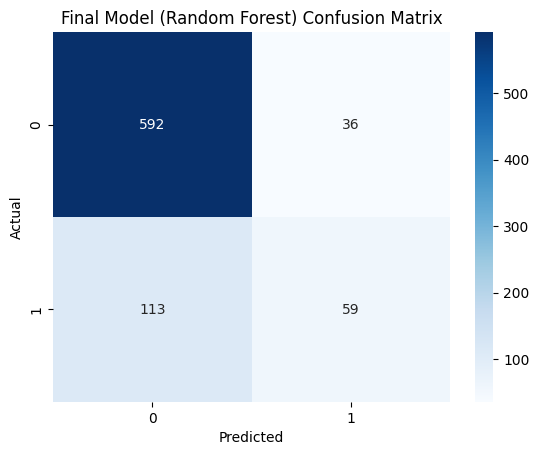

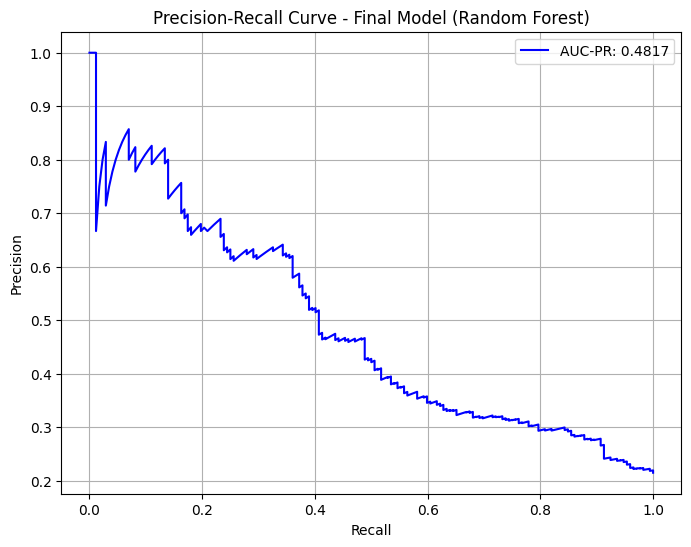

In [ ]:
# Predictions and evaluation on the test set
final_predictions = final_model.predict(X_test)
final_probabilities = final_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Compute metrics
final_precision = precision_score(y_test, final_predictions)
final_recall = recall_score(y_test, final_predictions)
final_f1 = f1_score(y_test, final_predictions)
final_roc_auc = roc_auc_score(y_test, final_probabilities)

print(f"Final Model (Random Forest) - Precision: {final_precision:.4f}, Recall: {final_recall:.4f}, F1-Score: {final_f1:.4f}, ROC AUC: {final_roc_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, final_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Final Model (Random Forest) Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Precision-Recall Curve
plot_precision_recall_curve(final_model, X_test, y_test, "Final Model (Random Forest)")

In [ ]:
# Save the trained model
model_path = "final_model_rf.pkl"
joblib.dump(final_model, model_path)
print(f"Model saved to {model_path}")

# Save the OneHotEncoder
encoder_path = "one_hot_encoder.pkl"
joblib.dump(encoder, encoder_path)
print(f"Encoder saved to {encoder_path}")

Model saved to final_model_rf.pkl
Encoder saved to one_hot_encoder.pkl


In [ ]:
from google.colab import files

# Download the model
files.download("final_model_rf.pkl")

# Download the encoder
files.download("one_hot_encoder.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Section E: Model Implementation**

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Load the saved model
model_path = "final_model_rf.pkl"
try:
    loaded_model = joblib.load(model_path)
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading the model: {e}")
    exit()

In [ ]:
# Example new data (replace with actual new data)
new_data = pd.DataFrame({
    'job': ['management'],
    'education': ['tertiary'],
    'marital_housing_interaction': ['married_yes'],
    'housing_loan_interaction': ['yes_no'],
    'contact_poutcome_interaction': ['cellular_success'],
    'previous': [1],
    'pdays': [30],
    'balance': [1500],
    'age': [45]
})

# Validate new data
if not new_data.empty:
    # Define categorical features (must match the training data)
    categorical_features = ['job', 'education', 'marital_housing_interaction',
                            'housing_loan_interaction', 'contact_poutcome_interaction']

    # Make sure the new data has the same features as the training data
    missing_features = set(categorical_features) - set(new_data.columns)
    if missing_features:
        print(f"Warning: Missing features in new data: {missing_features}")
    else:
        # Load the encoder
        encoder_path = "one_hot_encoder.pkl"
        try:
            encoder = joblib.load(encoder_path)
            print("Encoder loaded successfully.")
        except Exception as e:
            print(f"Error loading the encoder: {e}")
            exit()

        # Preprocess new data
        new_data_encoded = pd.concat([
            new_data.drop(columns=categorical_features).reset_index(drop=True),
            pd.DataFrame(encoder.transform(new_data[categorical_features]),
                         columns=encoder.get_feature_names_out(categorical_features))], axis=1)

        # Ensure column names are strings
        new_data_encoded.columns = new_data_encoded.columns.astype(str)

        # Make predictions
        new_predictions = loaded_model.predict(new_data_encoded)
        new_probabilities = loaded_model.predict_proba(new_data_encoded)

        # Output results
        print("Predictions:", new_predictions)
        print("Probabilities:", new_probabilities)

        # If true labels are available, evaluate the model
        y_true = np.array([1])  # Replace with actual true labels  #The length of y_true must match the number of rows in new_data.

        if 'y_true' in locals():
            print(f"Precision: {precision_score(y_true, new_predictions):.4f}")
            print(f"Recall: {recall_score(y_true, new_predictions):.4f}")
            print(f"F1 Score: {f1_score(y_true, new_predictions):.4f}")

            # Check if both classes are present in y_true
            if len(np.unique(y_true)) > 1:
               print(f"ROC AUC: {roc_auc_score(y_true, new_probabilities[:, 1]):.4f}")
            else:
               print("ROC AUC: Not defined (only one class present in y_true)")

            # Confusion Matrix with labels parameter
            cm = confusion_matrix(y_true, new_predictions, labels=[0, 1])
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
            plt.title("Confusion Matrix for New Data")
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.show()
else:
    print("No new data provided for prediction.")